In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from os import listdir
from os.path import isfile, join

import time

sns.set()

In [2]:
%matplotlib inline

## 1. Load and prepare data

In [3]:
# Load master song table with added metadata
master = pd.read_pickle('../data/master200.pkl')

In [4]:
print(master.shape)
display(master.head())

(999950, 25)


,artist_name,artist_uri,track_name,album_uri,duration_ms,album_name,count,track_uri,danceability,energy,...,instrumentalness,liveness,valence,tempo,time_signature,artist_genres,artist_popularity,album_genres,album_popularity,album_release_date
song_id,,,,,,,,,,,,,,,,,,,,,
0,Sidney Bechet's Blue Note Jazzmen,spotify:artist:2XouUSO0EAJ9gMMoHiXqMt,Muskrat Ramble,spotify:album:04hQBJ7YSuNnZ0nbuXNYbY,220293,Jazz Classics,1,spotify:track:0002yNGLtYSYtc0X6ZnFvp,0.455,0.623,...,0.903,0.6340,0.951,182.345,4,[],18,[],37,1993-01-01
159583,Sidney Bechet,spotify:artist:1RsmXc1ZqW3WBs9iwxiSwk,Blue Horizon,spotify:album:04hQBJ7YSuNnZ0nbuXNYbY,264933,Jazz Classics,5,spotify:track:1EWPMNHfdVNJwBpG9BcxXB,0.327,0.372,...,0.835,0.1530,0.380,66.036,4,"['bebop', 'big band', 'cool jazz', 'dixieland'...",52,[],37,1993-01-01
271702,Sidney Bechet,spotify:artist:1RsmXc1ZqW3WBs9iwxiSwk,Blame It On The Blues - Alternate Take,spotify:album:04hQBJ7YSuNnZ0nbuXNYbY,175893,Jazz Classics,1,spotify:track:26N4Y48EjprAtvlY6yWZTA,0.574,0.606,...,0.948,0.3490,0.965,101.361,4,"['bebop', 'big band', 'cool jazz', 'dixieland'...",52,[],37,1993-01-01
445190,Sidney Bechet,spotify:artist:1RsmXc1ZqW3WBs9iwxiSwk,Summertime,spotify:album:04hQBJ7YSuNnZ0nbuXNYbY,251906,Jazz Classics,16,spotify:track:3RlJx8xwZEyToSuGrygilr,0.608,0.138,...,0.908,0.0853,0.318,83.124,4,"['bebop', 'big band', 'cool jazz', 'dixieland'...",52,[],37,1993-01-01
626275,Sidney Bechet,spotify:artist:1RsmXc1ZqW3WBs9iwxiSwk,Dear Old Southland,spotify:album:04hQBJ7YSuNnZ0nbuXNYbY,243693,Jazz Classics,1,spotify:track:4qwAa1rOm8iaegHzoM1b31,0.400,0.320,...,0.842,0.1950,0.613,86.186,4,"['bebop', 'big band', 'cool jazz', 'dixieland'...",52,[],37,1993-01-01


There are some missing values here (throws an error if we try to fit a model). Drop rows with NA, as the remaining rows are those we intend to use.

In [5]:
old = master.shape
master.dropna(axis = 0, inplace = True)
print('Removed', old[0] - master.shape[0], 'observations')

Removed 9 observations


Convert `album_release_year` to a continuous number of the release year. The day of month or month itself of the release date is likely much less important. Should ideally treat as categorical, but this would give a *lot* of levels and not unreasonble to treat year as ordinal. 

In [6]:
master['album_release_year'] = np.array(
    [reldate[0:4] for reldate in master['album_release_date']], dtype = 'int')
master.drop(['album_release_date'], 1, inplace = True)

Several columns contain text (should be categorical):

Remove columns that we do not need:
- `album_genres` is always empty. Seems like a field that used to exist, but no longer does.
- `track_uri` is the url to the track. This is unique to each song and cannot be used to model. It is saved in the stored dataframe for reference if we need it later.
- `album_uri` for the same reason.
- `artist_uri` for the same reason.

Until we can effecrtively one-hot encode as categoricals, any remaining predictors of type `object` can be dropped, so that we only have numeric features.

In [7]:
master.drop(labels = ['album_genres', 'track_uri', 'album_uri', 'artist_uri'], 
           axis = 1, inplace = True)

Artist genres is missing for about $18\%$ of songs. For those that have it, it's a list of sometimes extremely specific genres. Hard to do something useful with, so drop it.

In [8]:
np.sum(master.artist_genres == '[]')/master.shape[0]

0.17600038402265733

We also can't do anything interest with track name (unless we want to try to use NLP to look for similarities in titles, but that seems like a stretch, so drop that too.

In [9]:
master.drop(['track_name', 'artist_genres'], 1, inplace = True)

Now whatever column is of type `object` is one we want to treat as categorical and one-hot-encode. Songs in the same album and/or by the same artist likely fit well together.  
  
**Note:** Perhaps redundant to keep both? If a song is in the same album, most of the time it will also be by the same artist? At the same time, collection albums may be a great way to indirectly capture genre information and relatedness beyond being by the same artist. There's just a *lot* of albums, i.e. we'll get a stupid amount of features with one-hot-encoding.

In [10]:
master.dtypes

artist_name            object
duration_ms             int64
album_name             object
count                   int64
danceability          float64
energy                float64
key                     int64
loudness              float64
mode                    int64
speechiness           float64
acousticness          float64
instrumentalness      float64
liveness              float64
valence               float64
tempo                 float64
time_signature          int64
artist_popularity       int64
album_popularity        int64
album_release_year      int64
dtype: object

## 2. Encode song-in-playlist indicators as sparse matrix
Load the list of lists saying which song IDs are in which playlists

In [11]:
# Read list of lists: parent index is playlist ID, child index is song in that playlist
playlists = pd.read_pickle('../data/playlists_song_ids_200.pkl')

# Give each parent list a number, i.e. playlist ID
play, song = zip(*enumerate(playlists))

# Expand into pairs of playlist-song, i.e. 100-long playlist becomes 100 pairs
pairs = [[z[0], s] for z in zip(play, song) for s in z[1]]

# column is song ID, row is playlist ID
col, row = zip(*pairs)
assert len(row) == len(col)

In [12]:
# Create sparse matrix
from scipy.sparse import csr_matrix, coo_matrix
mat = csr_matrix((np.ones(len(col), dtype = 'int'), (row, col)))
mat.shape

(1003760, 200000)

**Warning:** Usually `mat.A` gets you a dense matrix with zeros as zeros instead of simply being left out, *but* that will make Jupyter shit the bed due to the crazy memory requirements.

Various songs were ditched from the master songs table when adding metadata

In [13]:
mat = mat[master.index.values, :]
assert mat.shape[0] == master.shape[0]

Seems like it works: first playlist has 13 stored elements, corresponding to `len(playlists[0])`:

In [14]:
len(playlists[0]), mat[:, 0]

(13, <999941x1 sparse matrix of type '<class 'numpy.int64'>'
 	with 13 stored elements in Compressed Sparse Row format>)

#### Drop songs that occur below a certain threshold $n$

In [15]:
n = 5

In [16]:
songs_keep_ind = np.argwhere(np.sum(mat, axis = 1) >= n)[:,0]

Reduces from 1,000,000 songs to just north of 200,000.

In [17]:
mat_sub = mat[songs_keep_ind, :]
mat_sub.shape

(213675, 200000)

In [18]:
# Sparsity original
1 - (np.sum(mat)/(mat.shape[0]*mat.shape[1]))

0.9999346299381664

In [19]:
# Sparsity new subset
1 - (np.sum(mat_sub)/(mat_sub.shape[0]*mat_sub.shape[1]))

0.9997220166374167

Drop the same songs from the master songs metadata table

In [20]:
master_sub = master.iloc[songs_keep_ind, :]
master_sub.shape

(213675, 19)

Some playlists now have no songs or are very short. Drop those containing less than $m$ songs:

In [21]:
m = 10

In [22]:
p_sums = np.array(np.sum(mat_sub, axis = 0)).reshape((-1,))

Go from 200,000 playlists to just shy of 190,000

In [23]:
mat_sub = mat_sub[:, p_sums >= m]
mat_sub.shape

(213675, 187313)

Some songs now occur in no playlists, but ignore that. It's less than $10$ songs, this loop can go on forever, and we need to keep track of which we've kept with the above `songs_keep_ind`.

In [24]:
assert len(songs_keep_ind) == mat_sub.shape[0] == master_sub.shape[0]

Split out continuous data

In [33]:
master_sub_cont = master_sub.drop(['artist_name', 'album_name'], axis = 1)

Get song IDs corresponding to each row and feature names

In [34]:
songids = master_sub.index.values
cont_feats = list(master_sub_cont.columns)

In [35]:
len(cont_feats), cont_feats

(17,
 ['duration_ms',
  'count',
  'danceability',
  'energy',
  'key',
  'loudness',
  'mode',
  'speechiness',
  'acousticness',
  'instrumentalness',
  'liveness',
  'valence',
  'tempo',
  'time_signature',
  'artist_popularity',
  'album_popularity',
  'album_release_year'])

# 3. Data preparation
##### Prior to clustering: numerical and categorical data
There are ~30,000 artists and ~60,000 albums remaining. Together it is unreasonably high cardinality (many category levels), and we posit that artist is much more important than album. Hence, we ditch album.

## 3.1 Dimensionality reduction

### Hashing trick
**Note**: We have to do something to reduce the scope. Even if we try to use an AutoEncoder to reduce 30,000 one-hot-encoded binary indicators to fewer dimensions, it will run out of memory. We need to apply something like a hashing trick first.

For use with high-cardinality nominal categorical data.

Documentation: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.FeatureHasher.html

Read about it here: https://scikit-learn.org/stable/modules/feature_extraction.html#feature-hashing

And here: https://medium.com/value-stream-design/introducing-one-of-the-best-hacks-in-machine-learning-the-hashing-trick-bf6a9c8af18f

We *definitely* have a lot of hash collisions when we boil > 30,000 categorical levels down to only 1,000 hashed features.

In [36]:
from sklearn.feature_extraction import FeatureHasher

In [37]:
hasher = FeatureHasher(n_features = 1000, input_type = 'string')

In [38]:
#cats_hashed = hasher.fit_transform(master_sub[['artist_name', 'album_name']].values)
cats_hashed = hasher.fit_transform(master_sub['artist_name'].values)
cats_hashed

<213675x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 1967506 stored elements in Compressed Sparse Row format>

In [39]:
cats_hashed[0, 0:65].A

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]])

### Min-Max scale (i.e. *normalise*) data
Separately on the continuous variables and the hashed artist names, so we can run AutoEncoder on only the latter, encode it in a compressed space, and combine with minmax-scaled numerical data for clustering.

In [40]:
from sklearn.preprocessing import MinMaxScaler

Normalise continuous numerical data:

In [41]:
minmax = MinMaxScaler()
scaled_cont = minmax.fit_transform(master_sub_cont)

In [42]:
assert np.sum(np.amax(scaled_cont, axis = 0)) == master_sub_cont.shape[1]
assert np.sum(np.amin(scaled_cont, axis = 0)) == 0

Normalise hashed data:

In [43]:
minmax2 = MinMaxScaler()
scaled_artist = minmax2.fit_transform(cats_hashed.A)

## 3.2 Autoencoder
##### Further dimensionality reduction of categorical data
Inspired by: https://www.dlology.com/blog/how-to-do-unsupervised-clustering-with-keras/

Also by: https://www.analyticsvidhya.com/blog/2018/05/essentials-of-deep-learning-trudging-into-unsupervised-deep-learning/

**Note:** We extend this. Reproducing the hash solely with hashed data is a very hard task, so we give it additional input of the continuous data to help give context to learn which artist each song is associated with.

In [49]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

In [50]:
inputs = Input(shape = (scaled_artist.shape[1],))

encoder = Dense(500, activation = 'relu')(inputs)
encoder = Dense(500, activation = 'relu')(encoder)

# Compress into much lower-dimensional space
# Force lower-dimensional representation values between [0, 1] (like minmax)
encoder = Dense(20, activation = 'sigmoid')(encoder)

# Lossy decompression
decoder = Dense(500, activation = 'relu')(encoder)
decoder = Dense(500, activation = 'relu')(decoder)
decoder = Dense(scaled_artist.shape[1])(decoder)

autoencoder = Model(inputs, decoder)

Autoencoder maps raw input to its lossy reconstruction

In [51]:
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1000)]            0         
_________________________________________________________________
dense_6 (Dense)              (None, 500)               500500    
_________________________________________________________________
dense_7 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_8 (Dense)              (None, 20)                10020     
_________________________________________________________________
dense_9 (Dense)              (None, 500)               10500     
_________________________________________________________________
dense_10 (Dense)             (None, 500)               250500    
_________________________________________________________________
dense_11 (Dense)             (None, 1000)              5010

Encoder maps raw inputs to their encoded representation

In [52]:
encoder = Model(inputs, encoder)

Fit the beast

In [53]:
autoencoder.compile(optimizer = 'adam', loss = 'mse')

Validation split may seem low: we have 30,000 unique artists across 200,000 observations, so if the validation set is too large it will contain a lot of only observations of some artists, reducing the overall effectiveness of the autoencoder at capturing as much of the salient information as possible in its compressed space. Furthermore, 20,000 observations is still plenty to evaluate out-of-sample performance.

In [54]:
reconstruct_history = autoencoder.fit(
    scaled_artist, # Data is input,
    scaled_artist, # and output: try to reconstruct accurately
    epochs = 100,
    batch_size = 128,
    validation_split = 0.1,
    callbacks = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)],
    verbose = 1
)

Train on 192307 samples, validate on 21368 samples
Epoch 1/100
192307/192307 [==============================] - 43s 222us/sample - loss: 8.9128e-04 - val_loss: 3.0850e-04
Epoch 2/100
192307/192307 [==============================] - 45s 233us/sample - loss: 2.8371e-04 - val_loss: 2.7489e-04
Epoch 3/100
192307/192307 [==============================] - 42s 218us/sample - loss: 2.5008e-04 - val_loss: 2.3190e-04
Epoch 4/100
192307/192307 [==============================] - 42s 220us/sample - loss: 2.1203e-04 - val_loss: 2.3925e-04
Epoch 5/100
192307/192307 [==============================] - 42s 219us/sample - loss: 1.7813e-04 - val_loss: 1.7269e-04
Epoch 6/100
192307/192307 [==============================] - 43s 225us/sample - loss: 1.5144e-04 - val_loss: 1.4686e-04
Epoch 7/100
192307/192307 [==============================] - 43s 222us/sample - loss: 1.3159e-04 - val_loss: 1.3723e-04
Epoch 8/100
192307/192307 [==============================] - 45s 232us/sample - loss: 1.1927e-04 - val_loss: 

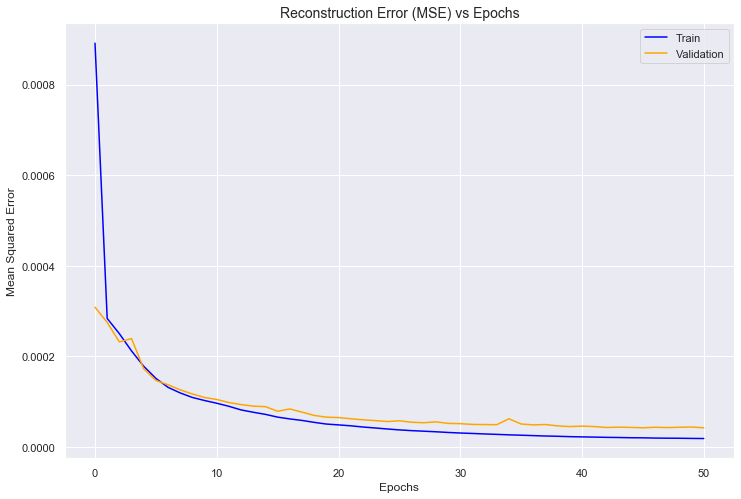

In [55]:
plt.figure(figsize = (12, 8))
plt.plot(reconstruct_history.history['loss'], c = 'blue', label = 'Train')
plt.plot(reconstruct_history.history['val_loss'], c = 'orange', label = 'Validation')
plt.title('Reconstruction Error (MSE) vs Epochs', fontsize = 14)
plt.ylabel('Mean Squared Error')
plt.xlabel('Epochs')
plt.legend()

**Encode data into compressed representation**

In [56]:
auto_artist = encoder.predict(scaled_artist)
auto_artist.shape

(213675, 20)

In [57]:
auto_artist[0]

array([0.299728  , 0.342897  , 0.3606518 , 0.51178825, 0.36301678,
       0.25996602, 0.34921724, 0.25537747, 0.30926043, 0.32384485,
       0.3476532 , 0.31975418, 0.30813247, 0.4850531 , 0.32485086,
       0.28372037, 0.3619985 , 0.30891663, 0.32840472, 0.68604153],
      dtype=float32)

## 3.3 Save everything so far

**Save to disk.** Pull song metadata from `master200` using song ID (index).

In [58]:
master_sub.to_pickle('../data/final/master_reduced.pkl')

In [59]:
np.save('../data/final/scaled_continuous_17wide', scaled_cont)

In [60]:
np.save('../data/final/scaled_artists_1000wide', scaled_artist)
np.save('../data/final/encoded_artists_20wide', auto_artist)

In [61]:
scaled_cont.shape, scaled_artist.shape, auto_artist.shape

((213675, 17), (213675, 1000), (213675, 20))